In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
import time

from util import SimpleNetwork
from util import PreprocessData
from util import CustomLoss
from util import CreateTensor
from util import DHO_setDataset, DHO_combDataset
from util import NeuralNetworkTrainer

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)
print(f"Training device: {device}")

# Model settings
model = SimpleNetwork(4, 1, 32, 8).to(device)
supervised = True
if supervised == True:
    model_name = f"supervised_pinn"
else:
    model_name = f"unsupervised_pinn"
num_epochs = 200_000
learning_rate = 1e-1
weight_decay = 1e-5
patience = 1000  # Number of epochs to wait for loss improvement

# Parameters
k_values = [100, 200, 300, 400, 500] # spring constant (N/m)
c_values = [2, 4, 6, 8, 10] # damping constant (N.s/m)
m_values = [0.5, 1.0, 1.5, 2.0, 2.5] # load mass (kg)
t_range = (0.0, 1.0) # time domin (sec)
num_samples = 1000
num_train_sets = 5  # Number of training sets to generate

# Create the dataset class instance
dataset = DHO_combDataset(k_values, c_values, m_values, t_range, num_samples)
training_sets = dataset.generate_dataset(num_train_sets)
test_set = (500, 10, 2.5)
test_dataset = dataset.generate_set(*test_set)


Training device: cuda


In [2]:
if __name__ == '__main__':
    print("Starting Training!")
    model.train()
    start_time = time.time()

    # Create an instance of the CustomLoss class
    custom_loss = CustomLoss(lam1=1e-1, lam2=1e-4, supervised=True)
    loss_log = {}

    print("Loading set data...")
    features = training_sets[['t', 'k', 'c', 'm']].values
    labels = training_sets[['x']].values
    # Creating tensors and Dataloader
    features_tensor, labels_tensor = CreateTensor(features, labels, device)
    dataset = TensorDataset(features_tensor, labels_tensor)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # Instantiate the NeuralNetworkTrainer class with appropriate parameters
    trainer = NeuralNetworkTrainer(model, learning_rate, custom_loss, weight_decay)
    loss_curve = trainer.train(train_loader, num_epochs, features_tensor, labels_tensor)

    end_time = time.time()  # Stop the timer
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds\n")
    print(f"Training finished!")

Starting Training!
Loading set data...


Training Progress:   0%|          | 1/200000 [00:02<158:07:15,  2.85s/it, Loss=0.246]

Epoch   109: reducing learning rate of group 0 to 1.0000e-02.


Training Progress:   0%|          | 2/200000 [00:03<99:39:55,  1.79s/it, Loss=0.00107] 

Epoch   210: reducing learning rate of group 0 to 1.0000e-03.


Training Progress:   0%|          | 5/200000 [00:06<64:23:59,  1.16s/it, Loss=5.91e-5]

Epoch   417: reducing learning rate of group 0 to 1.0000e-04.


Training Progress:   0%|          | 6/200000 [00:07<61:45:34,  1.11s/it, Loss=0.000331]

Epoch   518: reducing learning rate of group 0 to 1.0000e-05.


Training Progress:   0%|          | 7/200000 [00:08<60:44:23,  1.09s/it, Loss=0.000307]

Epoch   619: reducing learning rate of group 0 to 1.0000e-06.


Training Progress:   0%|          | 9/200000 [00:11<63:36:36,  1.15s/it, Loss=0.000301]

Epoch   720: reducing learning rate of group 0 to 1.0000e-07.


Training Progress:   0%|          | 10/200000 [00:12<65:03:49,  1.17s/it, Loss=0.000302]

Epoch   821: reducing learning rate of group 0 to 1.0000e-08.


Training Progress:   0%|          | 103/200000 [02:41<87:08:48,  1.57s/it, Loss=0.000302] 

Early stopping at epoch 104 due to lack of loss improvement.
Training time: 161.66 seconds

Training finished!


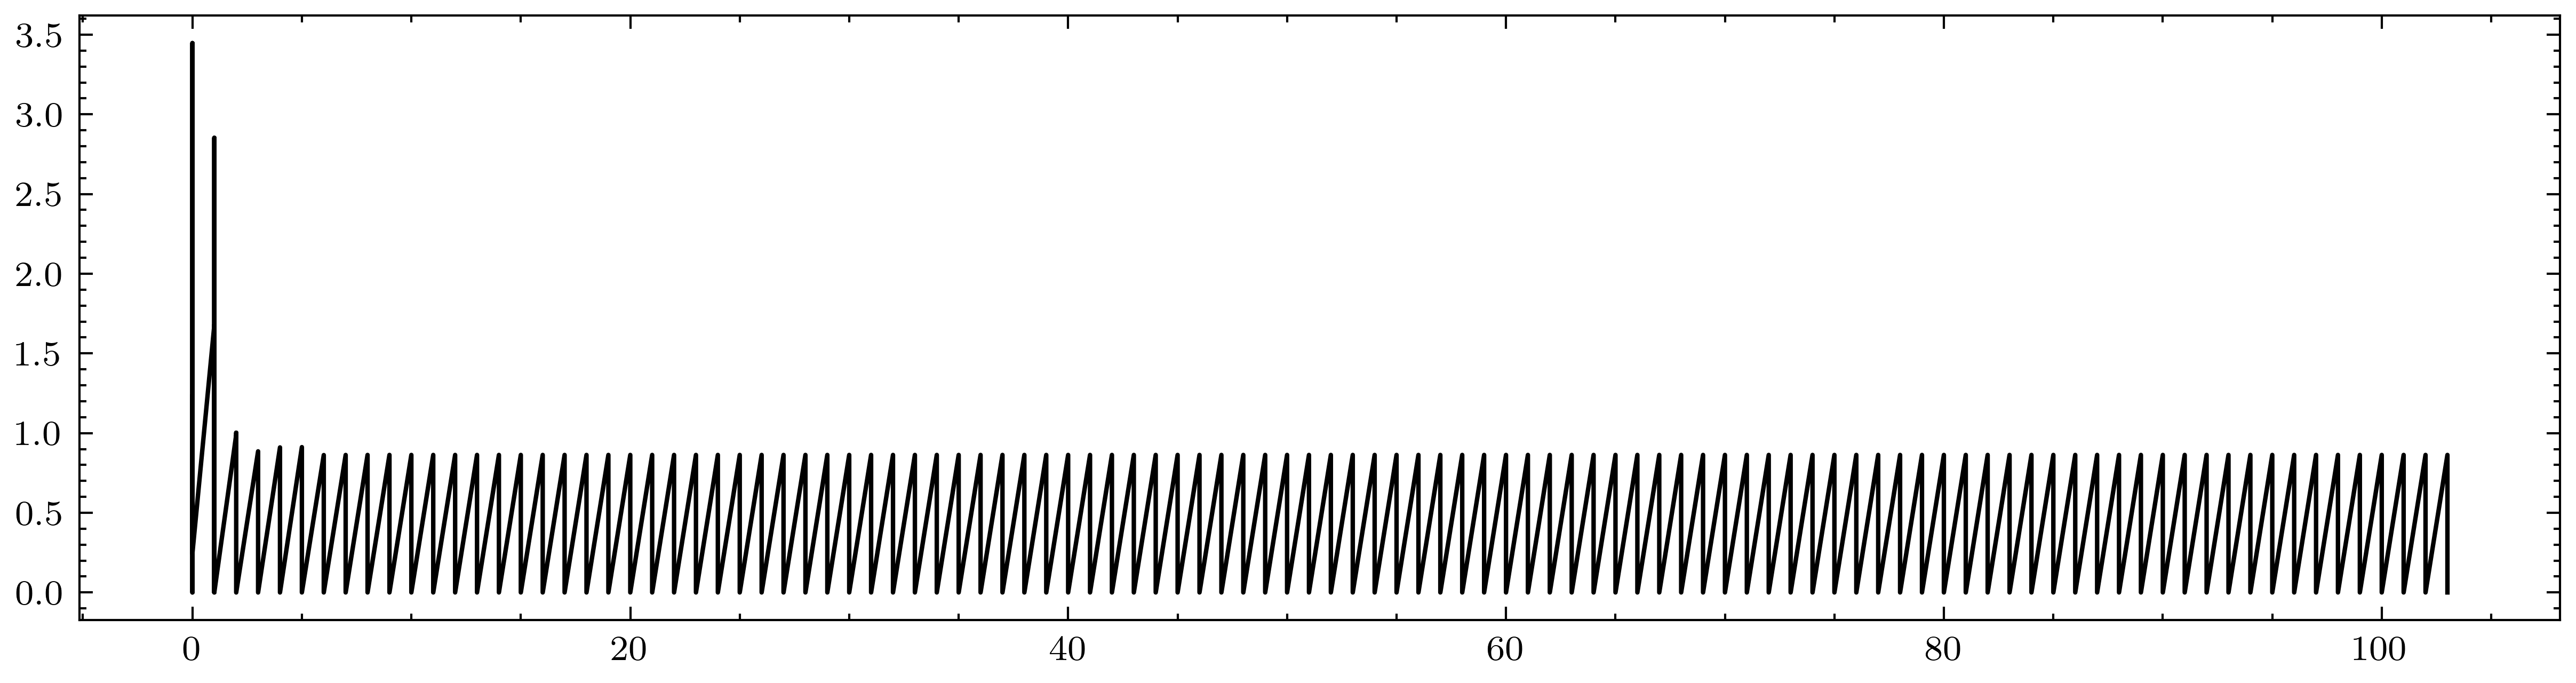

In [3]:
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(loss_curve['epoch'], loss_curve['loss'])
plt.show()